# Animal Influenza Emergence Risk Predictions
- **Note: Enet and Qnet are interchangeable, Qnet was the old name**
- Uses the Emergenet package to generate emergence risk scores for animal strains
- Collected animal HA and NA strains from January 1, 2020 - September 30, 2022
- Used Enets from `enet_models/current_enets/`

In [1]:
import os 
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
import math
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')
from Bio import SeqIO

# linear model
import statsmodels.api as sm
import statsmodels.formula.api as smf

# emergenet
from emergenet import Enet, save_model, load_model, irat_risk
from zedstat.textable import textable

In [2]:
DATA_DIR = 'raw_data/gisaid_animal/'
HUMAN_DATA_DIR = 'raw_data/gisaid_current/'
ENET_DIR = 'enet_models/current_enets/'
OUT_DIR = 'results/animal_predictions/'

NA_TRUNC = 449
HA_TRUNC = 550

FILES = ['h1n1', 'h1n2', 'h3n2', 'h5n1', 'h5n2', 'h5n6', 'h5n8', 'h7', 'h9n2']

In [3]:
# input: fasta file name, length to truncate each sequence
# output: dataframe of sequences (containing only name and accession)
def parse_fasta(file_name, trunc):
    name = []
    acc = []
    subtype = []
    for record in SeqIO.parse(file_name, 'fasta'):
        if len(record.seq) < trunc:
            continue
        name.append(record.id.split('|')[0])
        acc.append(record.id.split('|')[4])
        subtype.append(record.id.split('|')[1][-4:])
    df = pd.DataFrame({'id':name, 'subtype':subtype, 'accession':acc})
    return df

## Predictions
- For each animal strain, compute average NA and HA risk compared to human population of that strain
    - Do it 10 times for variance computation
    - For variance computation, compute 10 impact/emergence scores for each strain and take sample variance
    
### Running Processes

Computations are done in:
- `animal_predictions.py`
- `run_animal_predictions.sh`

To run, navigate to terminal and do

`chmod ugo+rwx run_animal_predictions.sh
./run_animal_predictions.sh`

## Scale Predictions with GLM

In [5]:
df_merged = pd.DataFrame({})

for FILE in tqdm(FILES):
    ha_df = parse_fasta(DATA_DIR + FILE + '_ha.fasta', HA_TRUNC)
    na_df = parse_fasta(DATA_DIR + FILE + '_na.fasta', NA_TRUNC)
    
    # df1: metadata
    df1 = ha_df.merge(na_df, how='inner', on='id').drop(columns=['subtype_y'])
    df1.rename(columns={'subtype_x':'subtype','accession_x':'ha_accession', 'accession_y':'na_accession'}, inplace=True)
    
    # df2: results
    df2 = pd.read_csv(OUT_DIR + FILE + '.csv')
    df2['ha_risk'] = df2['ha_risk'].apply(eval)
    df2['na_risk'] = df2['na_risk'].apply(eval)
    emergence_risks = []
    emergence_risks_var = []
    impact_risks = []
    impact_risks_var = []
    for i in range(len(df2)):
        ha = df2['ha_risk'].iloc[i]
        na = df2['na_risk'].iloc[i]
        emergence_risk = []
        impact_risk = []
        for j in range(10):
            er, ir = predict_irat(ha[j], na[j])
            emergence_risk.append(er)
            impact_risk.append(ir)
        emergence_risks.append(np.mean(emergence_risk))
        emergence_risks_var.append(np.var(emergence_risk))
        impact_risks.append(np.mean(impact_risk))
        impact_risks_var.append(np.var(impact_risk))
    df2['emergence_risk'] = emergence_risks
    df2['emergence_risk_var'] = emergence_risks_var
    df2['impact_risk'] = impact_risks
    df2['impact_risk_var'] = impact_risks_var
    
    # df3: merge df1 and df2
    df3 = df1.merge(df2, how='inner', on='id').drop_duplicates(subset=['id'])
    df3 = df3[df3['id'] != 'not_release_-_host_x_isolate_name_not_match']
    if len(df_merged) == 0:
        df_merged = df3
    else:
        df_merged = df_merged.append(df3, ignore_index=True)

df_merged.to_csv(OUT_DIR + 'combined_results.csv', index=False)

  0%|          | 0/9 [00:00<?, ?it/s]

## Results
- Merge with IRAT current results in `results/irat_average_qdistances_current.csv`
- Note that ha_accession and na_accession columns are the emergence and impact scores, respectively, for the IRAT table

In [132]:
# get accession for IRAT

def parse_fasta_irat(filepath):
    accs = []
    names = []
    for record in SeqIO.parse(filepath, 'fasta'):
        accs.append(_get_acc(str(record.description)))
        names.append(_get_name(str(record.description)))
    seq_df = pd.DataFrame({'name':names, 'acc':accs})
    return seq_df
    
def _get_acc(ID):
    ids = ID.split('|')
    # NCBI format
    if len(ids[0]) <= 12: 
        acc = ids[0]
        return acc
    # GISAID format
    else: 
        acc = ids[4]
        return acc

def _get_name(ID):
    ids = ID.split('|')
    # NCBI format
    if len(ids[0]) <= 12: 
        name = ''
        start = False
        for c in ids[1]:
            if c == '(' and not start:
                start = True
            elif c == '(' and start:
                break
            elif start == True:
                name += c
        return name
    # GISAID format
    else: 
        name = ids[0]
        return name
    
irat_df_ha = pd.DataFrame({'name':[], 'acc':[]})
irat_df_na = pd.DataFrame({'name':[], 'acc':[]})
IRAT_DIR = 'raw_data/irat_sequences/'
for file in os.listdir(IRAT_DIR):
    FILENAME = os.fsdecode(file)
    if FILENAME.endswith('_ha.fasta'): 
        df = parse_fasta_irat(IRAT_DIR + FILENAME)
        irat_df_ha = irat_df_ha.append(df)
    if FILENAME.endswith('_na.fasta'): 
        df = parse_fasta_irat(IRAT_DIR + FILENAME)
        irat_df_na = irat_df_na.append(df)
irat_df = irat_df_ha.merge(irat_df_na, how='inner', on='name')
irat_df.rename(columns={'acc_x':'ha_accession', 'acc_y':'na_accession'}, inplace=True)

In [135]:
# add column 'is_irat'
df_merged = pd.read_csv(OUT_DIR + 'combined_results.csv')
df_merged['is_irat'] = np.zeros(len(df_merged))

# load IRAT current predictions, change columns
df_irat = pd.read_csv('results/irat_predictions_current.csv')
df_irat = df_irat.merge(irat_df, how='left', 
                        left_on=df_irat['Influenza Virus'].str.lower(), 
                        right_on=irat_df['name'].str.lower().str.replace('_', ' '))
# for IRAT strains keep ACTUAL risk scores, not predicted
df_irat = df_irat[['Influenza Virus', 'Virus Type', 'ha_accession', 'na_accession',
                   'HA Sequence', 'NA Sequence', 'HA Qdistance', 'NA Qdistance', 'Geometric Mean',
                   'Potential Emergence Estimate', 'Emergence Risk Var.', 'Potential Impact Estimate', 'Impact Risk Var.']][:-1]
col_rename_dict = {i:j for i,j in zip(df_irat.columns, df_merged.columns)}
df_irat.rename(columns=col_rename_dict, inplace=True)
df_irat['is_irat'] = np.ones(len(df_irat))

# merge
df_merged = df_irat.append(df_merged)
df_merged.drop_duplicates(subset=['id'], inplace=True)
df_merged.set_index('id', inplace=True)

# manually input accessions for these strains
df_merged.at['A/Vietnam/1203/2004', 'ha_accession'] = 'AAT73274.1'
df_merged.at['A/Vietnam/1203/2004', 'na_accession'] = 'AAT73329.1'
df_merged.at['A/gyrfalcon/Washington/41088/2014', 'ha_accession'] = 'AJE30333.1'
df_merged.at['A/gyrfalcon/Washington/41088/2014', 'na_accession'] = 'AJE30335.1'
df_merged.at['A/American green-winged teal/Washington/1957050/2014', 'ha_accession'] = 'EPI573286'
df_merged.at['A/American green-winged teal/Washington/1957050/2014', 'na_accession'] = 'EPI573288'

df_merged.to_csv(OUT_DIR + 'combined_results_with_irat.csv')
df_merged.sort_values(by='emergence_risk', ascending=False).head(5)

,subtype,ha_accession,na_accession,ha,na,ha_risk,na_risk,geometric_mean_risk,emergence_risk,emergence_risk_var,impact_risk,impact_risk_var,is_irat
id,,,,,,,,,,,,,
A/swine/Shandong/1207/2016,H1N1,EPI1751427,EPI1751500,MEARLFVLFCAFTTLKADTICVGYHANNSTDTVDTILEKNVTVTHS...,MNPNQKIITIGSICMTIGIASLILQIGNIISIWISHSIQIENQNQS...,"[0.059268942695459764, 0.059207549599012387, 0...","[0.04153677158036683, 0.04121188550974603, 0.0...","[0.04961693798040306, 0.04939691038300986, 0.0...",7.500000,0.001861,6.900000,0.000003,1.0
A/swine/Missouri/A02524711/2020,H1N1,EPI1818121,EPI1818122,MKAILVVMLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGTANLILQIGNIISIWVSHSIQIGNQSQI...,"[0.007702821053332326, 0.00794167832708008, 0....","[0.0016000691389129699, 0.0019043683598783635,...","[0.0035107045233124007, 0.003888943420830784, ...",6.782248,0.000006,6.767254,0.000005,0.0
A/swine/Wisconsin/A02479131/2020,H1N1,EPI1780098,EPI1780099,MKAILVVMLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGTANLILQIGNIISIWVSHSIQIGNQSQI...,"[0.007716075008593186, 0.007954902925217054, 0...","[0.0016000691389129699, 0.0019043683598783635,...","[0.0035137235939651807, 0.0038921800365203044,...",6.782179,0.000006,6.767194,0.000005,0.0
A/swine/Missouri/A02479157/2020,H1N1,EPI1780243,EPI1780244,MKAILVVMLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGTANLILQIGNIISIWVSHSIQIGNQSQI...,"[0.007726353641666193, 0.007963408153388233, 0...","[0.0016000691389129699, 0.0019043683598783635,...","[0.003516063141975399, 0.0038942602024145657, ...",6.782131,0.000006,6.767151,0.000005,0.0
A/swine/North_Carolina/A02479181/2020,H1N1,EPI1780419,EPI1780420,MKAILVVMLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGTANLILQIGNIISIWVSHSIQIGNQSQI...,"[0.007702821053332326, 0.00794167832708008, 0....","[0.0016092572145346776, 0.0019136101393346001,...","[0.0035207698522261646, 0.003898368398450086, ...",6.782034,0.000006,6.767065,0.000005,0.0


In [136]:
# check IRAT strains, should be 22
df_merged[df_merged['is_irat'] == 1]

,subtype,ha_accession,na_accession,ha,na,ha_risk,na_risk,geometric_mean_risk,emergence_risk,emergence_risk_var,impact_risk,impact_risk_var,is_irat
id,,,,,,,,,,,,,
A/swine/Shandong/1207/2016,H1N1,EPI1751427,EPI1751500,MEARLFVLFCAFTTLKADTICVGYHANNSTDTVDTILEKNVTVTHS...,MNPNQKIITIGSICMTIGIASLILQIGNIISIWISHSIQIENQNQS...,"[0.059268942695459764, 0.059207549599012387, 0...","[0.04153677158036683, 0.04121188550974603, 0.0...","[0.04961693798040306, 0.04939691038300986, 0.0...",7.5,1.860546e-03,6.9,2.573638e-06,1.0
A/Ohio/13/2017,H3N2,EPI1056653,EPI1056652,MKTIIALSHILCLVFAQKLPGNDNNMATLCLGHHAVPNGTIVKTIT...,MNPNQKIITIGSVSLIIATICFLMQIAILVTTITLHFKQHNCDSSP...,"[0.007443436845452373, 0.007528108280118501, 0...","[0.0684551151913223, 0.06848866622907772, 0.06...","[0.02257302209884124, 0.0227066090672604, 0.02...",6.6,7.193062e-02,5.8,3.940741e-03,1.0
A/Hong Kong/125/2017,H7N9,EPI977395,EPI977394,MNTQILVFALIAIIPTNADKICLGHHAVSNGTKVNTLTERGVEVVN...,MNPNQKILCTSATAITIGAIAVLIGIANLGLNIGLHLKPGCNCSHS...,"[0.008053012400112526, 0.011702039255706398, 0...","[0.001702640937331002, 0.0015986998079791897, ...","[0.0037028892207661, 0.004325280096255358, 0.0...",6.5,5.773995e-02,7.5,2.592511e-03,1.0
A/Shanghai/02/2013,H7N9,EPI448936,EPI448938,MNTQILVFALIAIIPTNADKICLGHHAVSNGTKVNTLTERGVEVVN...,MNPNQKILCTSATAIIIGAIAVLIGMANLGLNIGLHLKPGCNCSHS...,"[0.0029756019607934496, 0.003893470493957003, ...","[0.0014946170772583095, 0.0014623661892494138,...","[0.00210888252534967, 0.002386143249933443, 0....",6.4,2.576900e-02,7.2,5.179005e-04,1.0
A/Anhui-Lujiang/39/2018,H9N2,EPI1315830,EPI1315828,METVSLITILLVATASNADKICIGYQSTNSTETVDTLTENNVPVTH...,MNPNQKITAIGSVSLIIAIICLLMQIAILTTTMTLHFGQKECSNPS...,"[0.013913606506215747, 0.014682700295856159, 0...","[0.025868069685588593, 0.04350993746295142, 0....","[0.018971508708604274, 0.025275351068975476, 0...",6.2,1.344396e-01,5.9,1.385737e-02,1.0
A/Indiana/08/2011,H3N2,EPI344405,EPI344404,MKTIIAFSCILCLIFAQKLPGSDNSMATLCLGHHAVPNGTLVKTIT...,MNPNQKIITIGSVSLIIATICFLMQIAILVTTVTLHFKQHDYNSPP...,"[0.015833187603574352, 0.01579698562348106, 0....","[0.018044038879410897, 0.017943339675641504, 0...","[0.016902504332314258, 0.01683599355230769, 0....",6.0,2.884250e-02,4.5,6.396291e-04,1.0
A/California/62/2018,H1N2,EPI1311361,EPI1311360,MKVKLMVLLCTFTATYADTICVGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSISLTLAAMCFLMQTAILVTNVTLHFNQCECHYPP...,"[0.25421003694129446, 0.17137241238504203, 0.1...","[0.04815654324714014, 0.037440724233825974, 0....","[0.11064301441040252, 0.08010185536798671, 0.0...",5.8,1.631650e-01,5.7,1.837041e-02,1.0
A/Bangladesh/0994/2011,H9N2,EPI445996,EPI445995,METVSLMTILLLVTTSNADKICIGHQSTNSTETVDTLTETNVPVTH...,MNPNQKIIALGSASLTIAIICLLIQIAILATTMTLHFMQNEHTNST...,"[0.047962278609110426, 0.047376021553330504, 0...","[0.475210595190095, 0.45959799525302836, 0.488...","[0.1509708016952567, 0.14755990149418968, 0.15...",5.6,3.646444e-02,5.4,7.804016e-04,1.0
A/Sichuan/06681/2021,H5N6,EPI1883261,EPI1883263,MENIVLLLAIVSLVKSDQICIGYHANNSTEQVDTIMEKNVTVTHAQ...,MNPNQKITCISATGVTLSIVSLLIGITNLGLNIGLHYKVSDSTTIN...,"[0.3401659563640977, 0.4372884849313668, 0.335...","[0.058431105437152214, 0.06210722573903746, 0....","[0.14098323610429828, 0.16479919492131653, 0.1...",5.3,8.323662e-02,6.3,4.040228e-03,1.0


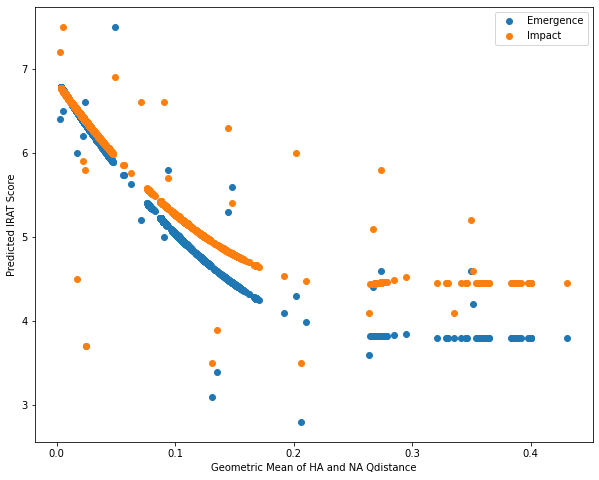

In [137]:
plt.figure(figsize = (10, 8))
plt.scatter(df_merged['geometric_mean_risk'].apply(eval).apply(np.mean), df_merged['emergence_risk'], label='Emergence')
plt.scatter(df_merged['geometric_mean_risk'].apply(eval).apply(np.mean), df_merged['impact_risk'], label='Impact')
plt.xlabel('Geometric Mean of HA and NA Qdistance')
plt.ylabel('Predicted IRAT Score')
plt.legend();
# points away from curve are IRAT sequences, with the actual IRAT score on Y axis

In [138]:
df_merged.groupby(by='subtype').count()['ha_accession']

subtype
H10N8       1
H1N1      939
H1N2      785
H3N2      829
H5N1     1601
H5N2       21
H5N6      142
H5N8     1384
H7N1        3
H7N2        1
H7N3       99
H7N5        1
H7N6        8
H7N7       12
H7N8        4
H7N9       21
H9N2      237
Name: ha_accession, dtype: int64